In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os
from numpy.lib.recfunctions import append_fields
import scipy.stats

import matplotlib.pyplot as plt
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

#debugging:
#import ipdb
#ipdb.set_trace()

# calling map 
path = '/fs/scratch/PCON0008/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits') #BAO is different measurement, may be different from this analysis
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

def calling_lens_catalog(catname=None):

    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
    os.system('mkdir '+catdir)
    dmass = esutil.io.read(catname)
    w_dmass = dmass['CMASS_PROB']
    print ('Calculating DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]   # for low probability galaxies
    ##esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')
    
    #randoms = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/random_dmass_y1_public_v1.fits')
#    randoms = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200_randoms.fits')
    
#    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
#    os.system('mkdir '+catdir)
#    dmass = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_sys_v3.fits')
    #w_dmass = dmass['CMASS_PROB'] *dmass['WEIGHT0_fwhm_r']*dmass['WEIGHT1_airmass_z']
    #print ('Calculatig DMASS systematic weights...')
    #dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    #dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]
    #esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

#    randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

    print ('Resulting catalog size')
    print ('DMASS=', np.sum(dmass['WEIGHT']) )
    #print ('randoms=', randoms.size)
    return dmass #, randoms

def keepEditedRegion(des):
    import healpy as hp
    import fitsio
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = LSSGoldmask['PIXEL']
    ind_good_ring = ringhp
    nside=4096
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0
    
    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des    

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------
# 2nd option: set seed -- get same randoms

# import DMASS in validation region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_spt = calling_lens_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')
# check prob cut
random_spt = uniform_random_on_sphere(dmass_spt, size = 10*int(np.sum(dmass_spt['WEIGHT']))) #larger size of randoms
# applying LSS mask 
random_spt = keepGoodRegion(random_spt)

random_spt = appendColumn(random_spt, value=np.ones(random_spt.size), name='WEIGHT')

path = '/fs/scratch/PCON0008/warner785/bwarner/'
fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')

phi = random_spt['RA'] * np.pi / 180.0
theta = ( 90.0 - random_spt['DEC'] ) * np.pi/180.0
random_pix = hp.ang2pix(4096, theta, phi)
print(random_pix.size)

frac = np.zeros(hp.nside2npix(4096))
fracDet["PIXEL"] = hp.nest2ring(4096, fracDet['PIXEL'])
#sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
frac[fracDet['PIXEL']] = fracDet['SIGNAL']
#fracHp = np.full(hp.nside2npix(4096), hp.UNSEEN)
#fracHp[fracDet['PIXEL']] = fracDet['SIGNAL']

frac_obj = frac[random_pix]

u = np.random.rand(len(random_pix))
#select random points with the condition u < frac_obj
random_val_fracselected = random_spt[u < frac_obj]

def cutPCA(sysMap):
    sysMap['PIXEL'] = hp.nest2ring(4096, sysMap['PIXEL'])
    RA, DEC = hp.pix2ang(4096, sysMap['PIXEL'], lonlat=True)
    sysMap = append_fields(sysMap, 'RA', RA, usemask=False)
    sysMap = append_fields(sysMap, 'DEC', DEC, usemask=False)
    #print(sysMap.dtype.names)

    sysMap = keepGoodRegion(sysMap)
    
# for spt region
    mask_spt = (sysMap['RA']>295)&(sysMap['RA']<360)|(sysMap['RA']<105)
    mask_spt = mask_spt & (sysMap['DEC']>-68) & (sysMap['DEC']<-10)
    sysMap = sysMap[mask_spt]
    
# for validation region
#    mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
#    mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
#    sysMap = sysMap[mask4]
    
 # for training region
    #mask = (sysMap['RA']>310) & (sysMap['RA']<360)|(sysMap['RA']<7)
    #mask = mask & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
    #sysMap = sysMap[mask]
    
    return sysMap

def number_gal(sysMap, dmass_chron, dmass_chron_weights, sys_weights = False): # apply systematic weights here
    
    minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    #minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
    #maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
    maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
    #maximum = np.max(sysMap['SIGNAL'][dim_mask])
    #print("min: ", minimum)
    #print("max: ", maximum)

    #pbin = np.linspace(-.03, .04, 1000)
    pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    pcenter = pbin[:-1] + pstep/2

    #x = np.zeros(hp.nside2npix(512))
    x = np.full(hp.nside2npix(4096), hp.UNSEEN)
    #print(x, sum(x))
    #x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
#    x[sysMap['HPIX_512']] = sysMap['SIGNAL']
    x[sysMap['PIXEL']] = sysMap['SIGNAL']

    #print(hp.visufunc.mollview(x)) # this is fine
    #print(hp.UNSEEN)

    #systematic value at galaxy location:

#    sysval_gal = x[dmass_chron['HPIX_512']].copy()
    sysval_gal = x[dmass_chron['HPIX_4096']].copy()

    #which healpixels have values in the sysMap signal

    #print(sum(sysval_gal[sysval_gal != hp.UNSEEN]))
    #print(hp.UNSEEN)

    #print(x.size, sysval_gal.size, dmass_chron.size)
    #print(maximum, minimum)
    #print((sysval_gal != 0.0).any())
    
    if sys_weights == True:
        print("weights being applied...")
        h,pedge1 = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN]*dmass_chron_weights[sysval_gal != hp.UNSEEN])
    else:
        h,pedge1 = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN]) # -- density of dmass sample, not gold sample
    #print(h)
    
    #print("pedge1: ", pedge1)
    #print("pbin: ", pbin)
    
    return h, sysval_gal

def area_pixels(sysMap, fracDet):
    
    #minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
    minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)

    pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    pcenter = pbin[:-1] + pstep/2
# number of galaxies in each pixel:

    sys_signal = sysMap['SIGNAL']

    ##n,_ = np.histogram(sys_signal[sys_signal != hp.UNSEEN] , bins=pbin )
#    print('area without weights:')
#    print(n)

    #corrected fracDet nside 512 //

    #matched_sys2 = sysMap[dim_mask]
    sys = sysMap
#    mask = np.full(hp.nside2npix(512), hp.UNSEEN)
    mask = np.full(hp.nside2npix(4096), hp.UNSEEN)

#    print(fracDet_512["HPIX_512"])
#    print(fracDet["PIXEL"])

    #Only look at pixels where fracDet has value
#    frac_mask = np.in1d(fracDet_512["HPIX_512"], sys["HPIX_512"], assume_unique=False, invert=False)
    frac_mask = np.in1d(fracDet["PIXEL"], sys["PIXEL"], assume_unique=False, invert=False)

    #make an array with signals corresponding to pixel values 
#    mask[sys["HPIX_512"]] = sys["SIGNAL"]
    mask[sys["PIXEL"]] = sys["SIGNAL"]

    #array only including fracDet/sys seen pixels sys signal values 
    #print(mask[mask != hp.UNSEEN])
#    frac_sys = mask[fracDet_512["HPIX_512"][frac_mask]]
    frac_sys = mask[fracDet["PIXEL"][frac_mask]]

    #weights of fracDet in the overlap applied for accurate areas
    ##area,_ = np.histogram(sys_signal[sys_signal != hp.UNSEEN] , bins=pbin , weights = frac_weight)
    area,_ = np.histogram(frac_sys[frac_sys != hp.UNSEEN] , bins=pbin , weights = fracDet["SIGNAL"][frac_mask][frac_sys != hp.UNSEEN])

    return area

def random_pixel(random_val_fracselected):
    phi = random_val_fracselected['RA'] * np.pi / 180.0
    theta = ( 90.0 - random_val_fracselected['DEC'] ) * np.pi/180.0
    nside= 4096

    HPIX_4096 = hp.ang2pix(4096, theta, phi)

    random_val = append_fields(random_val_fracselected, 'HPIX_4096', HPIX_4096, usemask=False)
    #print(random_val.dtype.names)
    
    return random_val

def number_density(sysMap, h, area):
    
    minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    #minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
    #maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
    maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
    #print(minimum)
    #print(maximum)

    pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    pcenter = pbin[:-1] + pstep/2
    # change to number density: divide by area

    #fig, ax = plt.subplots()
    #ax.errorbar( pcenter, h_ran)
    #ax.legend(chi2_reduced)
    #plt.title('number of random galaxies per bin')
    #fig.savefig('ran_gal_bin.pdf')

    #print(hp.visufunc.mollview(sysMap['SIGNAL'][dim_mask]))

    # h_ran = number of galaxies
    #print("number of random galaxies: ", h_ran)

    # number density in bins: h/area

    number_density = []
    for x in range(len(h)):
        den = h[x]/area[x]
        number_density.append(den)
    
    #print("randoms number density: ", number_density_ran)


    total_area = 0
    #Normalize based on total number density of used footprint:
    for x in range(len(area)):
        total_area += area[x]

    #print("total_area: ", total_area)

    # total galaxies:
    total_h = 0
    for x in range(len(h)):
        total_h += h[x]

    #print("total galaxies: ", total_h)

    #normalization: 
    total_num_density = total_h/total_area

    #print("total number density: ", total_num_density_ran)
    
    # apply normalization: 
    #print(number_density)
    norm_number_density = number_density/total_num_density
    #print(norm_number_density_ran)

    fracerr = np.sqrt(h) #1 / sqrt(number of randoms cmass galaxies in each bin)
    fracerr_norm = (fracerr/area)/total_num_density
    #print("normalized error: ", fracerr_ran_norm)
    
    return pcenter, norm_number_density, fracerr_norm


def chi2(norm_number_density, x2_value, fracerr_norm, n, covariance):
    #chi**2 values for qualitative analysis:
    # difference of (randoms-horizontal line)**2/err_ran**2
    x1 = norm_number_density
    x2 = x2_value
    cov = covariance
    if type(cov) != int:
        inv_cov = np.linalg.inv(cov)
    else:
        inv_cov = cov
    X = x1-x2
    Matrix = np.matrix(X)
    X_T = np.transpose(Matrix)
    chi2 = (Matrix)*inv_cov*X_T
    # add debug trace here
    sum_chi2=chi2[0][0]
    chi2_reduced = sum_chi2/(len(norm_number_density)-n)
    #else:
        #chi2_reduced = sum(chi2)/(chi2.size-n)  # n = 2 for linear fit, 3 for quad.
    #print("chi2: ",chi2_reduced)
    
    return sum_chi2, chi2_reduced

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 341117.6414259936


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:481: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


774423


In [2]:
chi2_randoms = []
chi2_dmassi = []
chi2_trend1 = []
chi2_trend2 = []
chi2_dmassf = []
trend = []

In [3]:
linear = True
quadratic = False

#if sys_weights == True:
#    dmass_chron =fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/dmass_sys_weight_'+current_map+'.fits')
dmass_chron_weights =fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/dmass_sys_weight_spt_custom_ALL.fits')
#        random_chron = fitsio.read('../output/test/train_cat/y3/'+input_keyword+'randoms.fits')

#else:
index_mask = np.argsort(dmass_spt)
dmass_chron = dmass_spt[index_mask] # ordered by hpix values
dmass_chron['HPIX_4096'] = hp.nest2ring(4096, dmass_chron['HPIX_4096']) 

#dmass_chron = appendColumn(dmass_chron, name='SYS_WEIGHT', value= dmass_chron_weights )

In [10]:
print(dmass_chron_weights)

[1.09354855 1.05463356 1.02977115 ... 0.83524449 1.18880618 0.87170674]


In [5]:
mock_outdir = '/fs/scratch/PCON0008/warner785/bwarner/'
n_pca = 1
cov = []
cov_template = 'cov{0}'
for i_pca in range(n_pca): #n_pca
    cov_input= cov_template.format(i_pca)
    cov.append(cov_input)
#print(cov)

cov_template = 'covariance{0}'
for i_pca in range(n_pca): #n_pca
    cov_keyword = cov_template.format(i_pca)
    #print(cov_keyword)
    with open(mock_outdir + cov_keyword + '.txt') as mocks:
        array1 = [x.split() for x in mocks]
        array2 = np.array(array1)
        print(i_pca)
        cov[i_pca] = array2.astype(float)
    mocks.close()

0


In [36]:
#for errors later

i_pca = [0,1,4,6,7,8,9,10,18,20,33]
total = 1
for x in range(11):
    num = i_pca[x]
    print(num)
    covariance = cov[num]
    cov = total*covariance
    total = cov
diag_cov = np.diagonal(cov)
error_cov = np.sqrt(diag_cov)

0
1
4
6
7
8
9
10
18


IndexError: index 18 is out of bounds for axis 0 with size 12

In [18]:
print(dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN]*dmass_chron_weights[sysval_gal != hp.UNSEEN])
print()
print(dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN])

[0.626169063682503 0.031178968781245032 0.3326090361613997 ...
 0.02330637346122698 0.012211849198101633 0.04906277190707514]

[0.5726028923242902 0.029563793438887067 0.3229931589638961 ...
 0.02790365434176101 0.010272363474491633 0.05628357525012588]


In [19]:
input_path = '/fs/scratch/PCON0008/warner785/bwarner/band_g/' 
#/band_g,r,i,z/:
#band = ['g', 'r', 'i', 'z']

#for x in range(4)
    #full_path = input_path + band[x] + '/'
#test weighted pca-dmass on the sp checks

#y3a2_g_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz
#y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz 
#y3a2_g_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 
#y3a2_g_o.4096_t.32768_SKYBRITE.WMEAN_EQU.fits.gz
#redmine
#nersc pca location for sp

sys_weights = True

covariance = cov[0]
diag_cov = np.diagonal(covariance)
error_cov = np.sqrt(diag_cov)

current_map = 'AIRMASSg'

input_keyword = 'y3a2_g_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz'
sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)

path = '/fs/scratch/PCON0008/warner785/bwarner/'
sysMap['PIXEL'] = hp.nest2ring(4096, sysMap['PIXEL'])

#frac_weight = fracHp[sysMap['PIXEL']]
#sysMap = sysMap[frac_weight != hp.UNSEEN]
#print(sum(frac_weight == hp.UNSEEN))

h_ran = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/h_ran_'+current_map+'.fits')
norm_number_density_ran = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/norm_ran_'+current_map+'.fits')
fracerr_ran_norm = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/fracerr_ran_'+current_map+'.fits')

print(dmass_chron_weights)
#sysMap = cutPCA(sysMap)
#fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')
#fracDet['PIXEL'] = hp.nest2ring(4096, fracDet['PIXEL'])

#    randoms4096 = random_pixel(random_val_fracselected)
#    index_ran_mask = np.argsort(randoms4096)
#    random_chron = randoms4096[index_ran_mask]
#    h_ran,_= number_gal(sysMap, random_chron, sys_weights = False)
#    area = area_pixels(sysMap, fracDet)
#    pcenter, norm_number_density_ran, fracerr_ran_norm = number_density(sysMap, h_ran, area)

h, sysval_gal = number_gal(sysMap, dmass_chron, dmass_chron_weights, sys_weights = True) # change this to true if sys weights run
area = area_pixels(sysMap, fracDet)
pcenter, norm_number_density, fracerr_norm = number_density(sysMap, h, area)


Calling catalogs >>>
y3a2_g_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz
reading 1/1 /fs/scratch/PCON0008/warner785/bwarner/band_g/y3a2_g_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz
[1.09354855 1.05463356 1.02977115 ... 0.83524449 1.18880618 0.87170674]


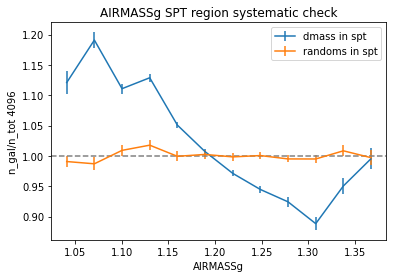

In [20]:
#plotting:

fig, ax = plt.subplots()
ax.errorbar( pcenter, norm_number_density, yerr=error_cov, label = "dmass in spt")
ax.errorbar( pcenter, norm_number_density_ran, yerr=fracerr_ran_norm, label = "randoms in spt")
plt.legend()
xlabel = input_keyword
plt.xlabel(current_map)
plt.ylabel("n_gal/n_tot 4096")
#plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
#plt.ylim(bottom=0.85)
plt.axhline(y=1, color='grey', linestyle='--')
#    plt.title(xlabel+' systematic check')
if sys_weights == True:
    plt.title(current_map+' SPT region systematic check')
    #fig.savefig(current_map+' spt_without.pdf')
else:
    plt.title('systematics check: '+current_map+' in spt')
    #fig.savefig(current_map+'spt.pdf')  

In [21]:
ran_chi2, ran_chi2_reduced = chi2(norm_number_density_ran, 1, fracerr_ran_norm, 0)
print('ran_chi2: ', ran_chi2_reduced)
chi2_randoms.append(ran_chi2_reduced)
    
if sys_weights == True:
    trend_chi2, trend_chi2_reduced = chi2(norm_number_density, 1, fracerr_norm, 0)
    print('applied_sys_chi2: ', trend_chi2_reduced)
    chi2_dmassf.append(trend_chi2_reduced)
    
if sys_weights == False:    
    dmass_chi2, dmass_chi2_reduced = chi2(norm_number_density, 1, fracerr_norm, 0)
    print('checking chi2 before correction: ', dmass_chi2_reduced)
    chi2_dmassi.append(dmass_chi2_reduced)

ran_chi2:  0.7206945841093119
checking chi2 before correction:  10.376403224608577


In [18]:
print(chi2_randoms)
print(chi2_dmassi)
print(chi2_dmassf)

np.savetxt('chi2_randoms_spt.txt', chi2_randoms)
np.savetxt('chi2_dmass_airmass_spt.txt', chi2_dmassi)

[0.9057029782733329, 1.5073738043110143, 1.0736437038081252, 1.2542362125456188]
[6.794675520527439, 10.50000466139566, 4.859834994664206, 1.82327447800456]
[]
